In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ../..

/scratch/km817/iREC


In [4]:
import torch
import hamiltorch
import matplotlib.pyplot as plt
import torch.distributions as D
import torch.nn as nn
import torch.nn.functional as F

In [5]:
%matplotlib inline

In [6]:
hamiltorch.set_random_seed(0)
device = torch.device('cpu')

In [7]:
hamiltorch.__version__

'0.4.0.dev1'

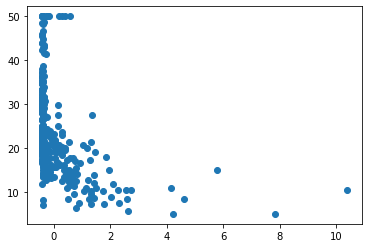

In [24]:
from sklearn.datasets import load_boston
import numpy as np

data = load_boston()

x_ = data['data']
y_ = data['target']
N_tr = int(x_.shape[0] * 0.8)
N_val = x_.shape[0] - N_tr
a = np.arange(x_.shape[0])
train_index = np.random.choice(a, size = N_tr, replace = False)
val_index = np.delete(a, train_index, axis=0)
x_train = x_[train_index]
y_train = y_[train_index]
x_val = x_[val_index][:]
y_val = y_[val_index][:]
x_m = x_train.mean(0)
x_s = x_train.std(0)
x_train = (x_train-x_m)/ x_s
x_val = (x_val-x_m)/ x_s

D_in = x_train.shape[1]
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)
plt.scatter(x_train.numpy()[:,0],y_train.numpy())
    
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val = x_val.to(device)
y_val = y_val.to(device)

In [25]:
x_.shape[0]

506

In [26]:
from models.BNNs.DeterministicNN import Deterministic_NN

In [85]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# if torch.cuda.is_available():
#     print(torch.cuda.get_device_name(0))

device=torch.device('cpu')

class Net(nn.Module):
    def __init__(self, num_nodes: int = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(D_in, num_nodes)
        self.fc2 = nn.Linear(num_nodes, num_nodes)
        self.fc3 = nn.Linear(num_nodes, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

num_nodes = 2
alpha = 1.
beta = 1.
ELBO_BETA = 1.
net = Net(num_nodes=num_nodes)

# MF-VI Approx

In [86]:
from models.BNNs.SimpleBBPBNN import SimpleBBPBNN, train_bnn
from models.BNNs.pyroVIBNN_BOSTON import BayesianNeuralNetwork
from pyro.infer.autoguide import AutoDiagonalNormal
import pyro
import pyro.distributions as dist
from tqdm.notebook import trange

In [87]:
# create models
model = BayesianNeuralNetwork(in_features=D_in, prior_var=1./alpha, likelihood_var=1./beta * ELBO_BETA, hidden_nodes=num_nodes)
guide = AutoDiagonalNormal(model)

In [88]:
from pyro.infer import SVI, TraceMeanField_ELBO

adam = pyro.optim.Adamax({"lr": 5e-1})
svi = SVI(model, guide, adam, loss=TraceMeanField_ELBO())

num_iterations = 10000
pyro.clear_param_store()
for j in trange(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_train, y_train)
    if j % 1000 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))

guide.requires_grad_(False)

params = []
for name, value in pyro.get_param_store().items():
    params.append(pyro.param(name))

  0%|          | 0/10000 [00:00<?, ?it/s]

[iteration 0001] loss: 297.7158
[iteration 1001] loss: 8.2455
[iteration 2001] loss: 7.9838
[iteration 3001] loss: 8.0146
[iteration 4001] loss: 7.6451
[iteration 5001] loss: 8.2446
[iteration 6001] loss: 8.0917
[iteration 7001] loss: 8.0062
[iteration 8001] loss: 7.8583
[iteration 9001] loss: 7.5525


In [89]:
stds ** 2

tensor([0.3155, 0.2639, 0.1410, 0.2041, 0.2516, 0.1981, 0.2514, 0.2200, 0.1443,
        0.1272, 0.1767, 0.3276, 0.2824, 1.0548, 1.0208, 1.0230, 1.0022, 0.9740,
        1.0030, 0.9034, 1.0751, 0.8028, 1.1615, 1.1706, 0.9739, 1.0497, 0.1799,
        0.9708, 0.1472, 0.1252, 0.0147, 0.0144, 0.1168, 0.0121, 0.1922, 0.2698,
        0.1824])

In [90]:
model_loss = 'regression'

# Effect of tau
tau = alpha # Prior Precision
tau_out = beta # Output Precision

tau_list = []
for w in net.parameters():
    tau_list.append(tau) # set the prior precision to be the same for each set of weights
tau_list = torch.tensor(tau_list).to(device)

mean, stds = params

variational_posterior = dist.MultivariateNormal(loc=mean, covariance_matrix=torch.diag(stds ** 2))

variational_samples = variational_posterior.sample((1000,))
pred_list_var_exact, log_probs_f = hamiltorch.predict_model(net, x = x_train.to(device),
                                                  y = y_train.to(device), samples=variational_samples,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

In [91]:
pred_list_var_exact.mean(0)

tensor([[14.6255],
        [21.3738],
        [19.4515],
        [10.6187],
        [45.3644],
        [18.3902],
        [20.9343],
        [16.8235],
        [18.6989],
        [15.7323],
        [19.6294],
        [21.2925],
        [19.7600],
        [19.0026],
        [15.5489],
        [17.2705],
        [21.4672],
        [10.5154],
        [21.9479],
        [29.4533],
        [11.1561],
        [13.6361],
        [19.2594],
        [37.0658],
        [20.9414],
        [28.3672],
        [10.6288],
        [26.3009],
        [23.4187],
        [22.2567],
        [18.5154],
        [44.9236],
        [16.1034],
        [19.4130],
        [17.0418],
        [21.7459],
        [19.2023],
        [25.3464],
        [19.0080],
        [11.6887],
        [26.2452],
        [25.0940],
        [24.8950],
        [18.2906],
        [20.8168],
        [18.5510],
        [20.8066],
        [20.5262],
        [22.6885],
        [16.8148],
        [14.8170],
        [11.3195],
        [18.

In [92]:
prior = D.MultivariateNormal(loc=torch.zeros_like(mean), covariance_matrix = 1./alpha * torch.eye(mean.shape[-1]))
D.kl_divergence(variational_posterior, prior)

tensor(517.1501)

# Compress some weights with variational scheme

In [ ]:
#### sample weights with compression algorithm
from rec.beamsearch.Coders.Encoder_Variational import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.OptimisingVars.VariationalOptimiser import VariationalOptimiser
from tqdm.notebook import trange
coding_sampler = CodingSampler
auxiliary_posterior = VariationalPosterior
selection_sampler = GreedySampler
omega = 5

initial_seed = 0
beamwidth = 1
epsilon = 0.



compute_params_enc =  encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)

n_auxiliaries = compute_params_enc.n_auxiliary
kl_q_p = compute_params_enc.total_kl
var_opt = VariationalOptimiser(compute_params_enc.target, omega, n_auxiliaries, kl_q_p, n_trajectories=16, total_var=1./alpha)
aux_vars = var_opt.run_optimiser(epochs=5000, lr=1e-1)

In [ ]:
kl_q_p

In [ ]:
initial_seed = 0
beamwidth = 1
epsilon = 0.

compressed_weights_low_eps = []
num_compressed_samples = 250
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_low_eps.append(w[0])

In [ ]:
pred_list_var_low_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_low_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)

plot_preds(pred_list_var_low_eps)

In [ ]:
initial_seed = 0
beamwidth = 1
epsilon = 0.1

compressed_weights_var_med_eps = []
num_compressed_samples = 250
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_var_med_eps.append(w[0])

In [ ]:
pred_list_var_med_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_var_med_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)
plot_preds(pred_list_var_med_eps)

In [ ]:
initial_seed = 0
beamwidth = 1
epsilon = 0.2

compressed_weights_var_high_eps = []
num_compressed_samples = 250
for i in trange(num_compressed_samples):
    initial_seed = initial_seed + i * 10
    encoder = Encoder(variational_posterior,
                      initial_seed,
                      coding_sampler,
                      selection_sampler,
                      auxiliary_posterior,
                      omega,
                      epsilon=epsilon,
                      beamwidth=beamwidth,
                      prior_var=1./alpha)
    
    encoder.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
    w, idx = encoder.run_encoder()

    compressed_weights_var_high_eps.append(w[0])

In [ ]:
pred_list_var_high_eps, log_probs_f = hamiltorch.predict_model(net, x = xs.to(device),
                                                  y = xs.to(device), samples=compressed_weights_var_high_eps,
                                                  model_loss=model_loss, tau_out=tau_out,
                                                  tau_list=tau_list)
plot_preds(pred_list_var_high_eps)

In [ ]:
def make_empirical_predictive(weights, x_input, y_output):
    pred_list, _ = hamiltorch.predict_model(net, x = x_input.flatten().to(device),
                                                  y = y_output.flatten().to(device), samples=weights,
                                                  model_loss='regression', tau_out=tau_out,
                                                  tau_list=tau_list)
    
    # need to make gmm at each sample
    return pred_list

def make_empirical_gmm(preds):
    mix = D.Categorical(torch.ones(preds.shape[0]))
    comp = D.Normal(loc=preds.squeeze().permute(1, 0), scale=beta ** -0.5)
    gmm = D.MixtureSameFamily(mix, comp)
    return gmm

def compute_gmm_lp(weights, x, y):
    preds = make_empirical_predictive(weights, x, y)
    
    gmm = make_empirical_gmm(preds)
    
    return gmm.log_prob(y.squeeze()).sum()

In [ ]:
compute_gmm_lp(variational_samples, x_test, y_test)

In [ ]:
compute_gmm_lp(variational_samples, x_data, y_data)

In [ ]:
compute_gmm_lp(compressed_weights_low_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_var_med_eps, x_test, y_test)

In [ ]:
compute_gmm_lp(compressed_weights_var_high_eps, x_test, y_test)

In [ ]:
# dump the important stuff
import pickle as pkl
pkl.dump(variational_posterior, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_post_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(aux_vars, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_optimised_vars_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(kl_q_p, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_kl_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(variational_samples, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_exact_beta_{ELBO_BETA}.pkl', 'wb'))
pkl.dump(compressed_weights_low_eps, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_beta_{ELBO_BETA}_eps_0.pkl', 'wb'))
pkl.dump(compressed_weights_var_med_eps, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_beta_{ELBO_BETA}_eps_0.1.pkl', 'wb'))
pkl.dump(compressed_weights_var_high_eps, open(f'PickledStuff/BNN_BETA_RESULTS/VAR/var_beta_{ELBO_BETA}_eps_0.2.pkl', 'wb'))